# ResNet

##Preparation Part

In [ ]:
# Import Libraries
import numpy as np
import time
import os
# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
# Import torch vision
import torchvision
from torchvision import datasets, models, transforms 
# Import plot
import matplotlib.pyplot as plt

In [ ]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# CUDA and GPU 
!nvidia-smi
use_cuda = True

Tue Apr  5 00:46:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    62W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Dataset Loading Part

In [ ]:
from torchvision.transforms.transforms import Resize
# DIfferent directories
jeff_dir = '/content/gdrive/MyDrive/APS360-Project/Dataset_3/'
charlie_dir = '/content/gdrive/MyDrive/ECE/2022Winter/APS360/Dataset/'
dylan_dir = '/content/gdrive/MyDrive/APS360Project/Dataset_combined/'
# Choose directory
data_dir = dylan_dir

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform = transform)
val_data = datasets.ImageFolder(val_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))
print('Number of testing images: ', len(test_data))


Number of training images:  18010
Number of validation images:  3852
Number of testing images:  3852


In [ ]:
def data_loader(train_data, val_data, test_data, batch_size, num_workers = 1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    return train_loader, val_loader, test_loader;

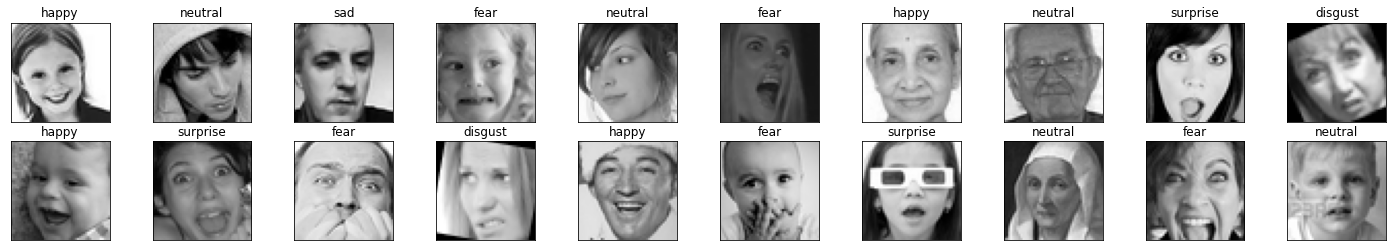

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader = data_loader(train_data, val_data, test_data, batch_size)
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

##Helper Functional Part

In [ ]:
def get_stastics(model, data, batch_size):

  correct, total = 0, 0
  running_corrects, running_loss = 0.0, 0
  criterion = nn.CrossEntropyLoss()

  for imgs, labels in data:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    output = model(imgs)
    loss = criterion(output, labels)
    
    #select index with maximum prediction score
    preds = output.max(1, keepdim=True)[1]

    # Get Accuracy
    correct += preds.eq(labels.view_as(preds)).sum().item()
    total += imgs.shape[0]
    accuracy = correct / total

    # Get F1 score
    running_loss += loss.item() * imgs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    from sklearn.metrics import f1_score

    f1_score = f1_score(labels.cpu().data, preds.cpu(), average='micro')

  return accuracy, f1_score

In [ ]:
def train(model, train_data, val_data, batch_size=64, learning_rate = 0.01, num_epochs=1):
  torch.manual_seed(1000) # set the random seed

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, train_acc, val_acc, train_f1, val_f1 = np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs)

  # training
  n = 0 # the number of iterations
  start_time=time.time()
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_data):
    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
    
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    # save the current training statistics
    iters[epoch] = n

    train_acc[epoch], train_f1[epoch] = get_stastics(model, train_data, batch_size=batch_size) # compute training 
    val_acc[epoch], val_f1[epoch] = get_stastics(model, val_data, batch_size=batch_size)  # compute validation 

    n += 1

    print ("Epoch %d Finished." % epoch, "Training Accuracy is", train_acc[epoch],
           "Validation Accuracy is", val_acc[epoch], ". Validation F1 score is", val_f1[epoch])

  # save models for later usage
  model_path = "/content/gdrive/MyDrive/APS360Project/Model_ResNet_new"
  torch.save(model.state_dict(), model_path)

  end_time= time.time()
  
  # plotting
  plt.title("F1 Score Curve")
  plt.plot(iters, train_f1, label="Training")
  plt.plot(iters, val_f1, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Accuracy Curve")
  plt.plot(iters, train_acc, label="Training")
  plt.plot(iters, val_acc, label="Validation")    
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("Final Training F1 Score: {}".format(train_f1[-1]))
  print("Final Validation F1 Score: {}".format(val_f1[-1]))

##Neural Network Part

# Model 0

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from torch.nn.modules import dropout
from torch.nn.modules.activation import ReLU

In [ ]:
resnet_model = models.resnet.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(1000, 50),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(50, 6)
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=15)

CUDA is available...
Epoch 0 Finished. Training Accuracy is 0.46244444444444444 Validation Accuracy is 0.41455204557224234 . Validation F1 score is 0.3181818181818182
Epoch 1 Finished. Training Accuracy is 0.49933333333333335 Validation Accuracy is 0.4142931123770067 . Validation F1 score is 0.45454545454545453
Epoch 2 Finished. Training Accuracy is 0.5418888888888889 Validation Accuracy is 0.4520973588814086 . Validation F1 score is 0.6363636363636364
Epoch 3 Finished. Training Accuracy is 0.5691666666666667 Validation Accuracy is 0.47928534438114967 . Validation F1 score is 0.5
Epoch 4 Finished. Training Accuracy is 0.6095555555555555 Validation Accuracy is 0.5106162610046608 . Validation F1 score is 0.4090909090909091
Epoch 5 Finished. Training Accuracy is 0.6345 Validation Accuracy is 0.5056965302951838 . Validation F1 score is 0.2727272727272727
Epoch 6 Finished. Training Accuracy is 0.6354444444444445 Validation Accuracy is 0.4795442775763853 . Validation F1 score is 0.3636363636

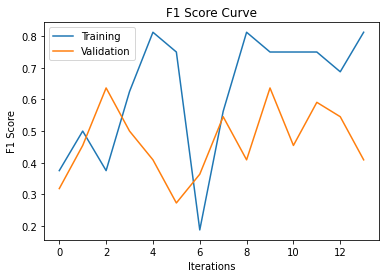

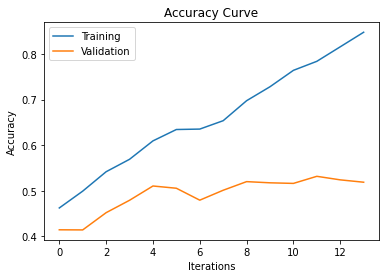

Final Training Accuracy: 0.8478333333333333
Final Validation Accuracy: 0.518902123252201
Final Training F1 Score: 0.8125
Final Validation F1 Score: 0.4090909090909091


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available:
    print('CUDA is available...')

train(resnet_model, train_loader, val_loader, batch_size=32, learning_rate=0.001, num_epochs=14)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available:
    print('CUDA is available...')

train(resnet_model, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=20)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=20)

# Model 1

In [ ]:
resnet_model_1 = models.resnet.resnet18(pretrained=True)
num_ftrs = resnet_model_1.fc.in_features
resnet_model_1.fc = nn.Linear(num_ftrs, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model_1 = resnet_model_1.to(device)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.61188228761799 Validation Accuracy is 0.5051921079958464 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Training Accuracy is 0.6589117157134925 Validation Accuracy is 0.5249221183800623 . Validation F1 score is 0.5
Epoch 2 Finished. Training Accuracy is 0.6837867851193781 Validation Accuracy is 0.5306334371754933 . Validation F1 score is 0.6666666666666666
Epoch 3 Finished. Training Accuracy is 0.7583009439200444 Validation Accuracy is 0.5501038421599169 . Validation F1 score is 0.6666666666666666
Epoch 4 Finished. Training Accuracy is 0.8138256524153248 Validation Accuracy is 0.5417964693665628 . Validation F1 score is 0.6666666666666666
Epoch 5 Finished. Training Accuracy is 0.8518045530260966 Validation Accuracy is 0.5399792315680166 . Validation F1 score is 0.75
Epoch 6 Finished. Training Accuracy is 0.8938922820655192 Validation Accuracy is 0.5560747663551402 . Validation F1 score is 0.

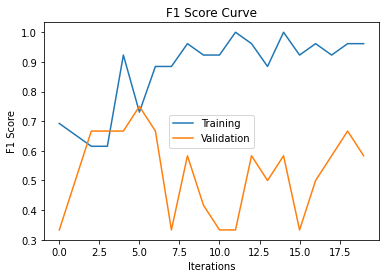

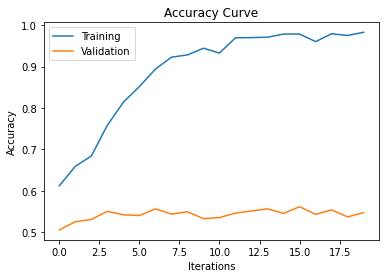

Final Training Accuracy: 0.9830094392004441
Final Validation Accuracy: 0.5472481827622014
Final Training F1 Score: 0.9615384615384616
Final Validation F1 Score: 0.5833333333333334


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=20)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=32, learning_rate=0.01, num_epochs=20)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6054414214325374 Validation Accuracy is 0.5025960539979232 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Training Accuracy is 0.6715713492504164 Validation Accuracy is 0.5358255451713395 . Validation F1 score is 0.5833333333333334
Epoch 2 Finished. Training Accuracy is 0.715824541921155 Validation Accuracy is 0.5459501557632399 . Validation F1 score is 0.75
Epoch 3 Finished. Training Accuracy is 0.7491948917268184 Validation Accuracy is 0.5399792315680166 . Validation F1 score is 0.25
Epoch 4 Finished. Training Accuracy is 0.8113825652415325 Validation Accuracy is 0.5399792315680166 . Validation F1 score is 0.6666666666666666
Epoch 5 Finished. Training Accuracy is 0.8533037201554692 Validation Accuracy is 0.5402388369678089 . Validation F1 score is 0.5833333333333334
Epoch 6 Finished. Training Accuracy is 0.8931149361465852 Validation Accuracy is 0.5464693665628245 . Validation F1 score is 

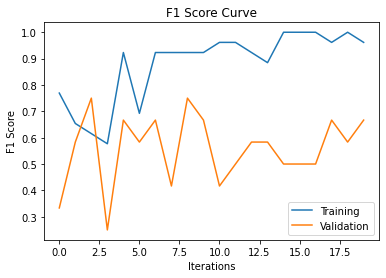

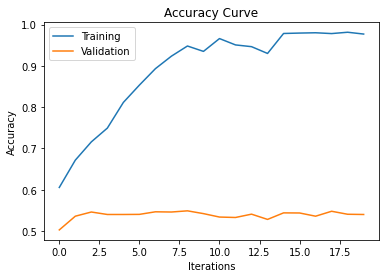

Final Training Accuracy: 0.9769572459744587
Final Validation Accuracy: 0.5399792315680166
Final Training F1 Score: 0.9615384615384616
Final Validation F1 Score: 0.6666666666666666


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=32, learning_rate=0.001, num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6177679067184897 Validation Accuracy is 0.5173935617860852 . Validation F1 score is 0.5833333333333334
Epoch 1 Finished. Training Accuracy is 0.6549139367018323 Validation Accuracy is 0.534527518172378 . Validation F1 score is 0.5
Epoch 2 Finished. Training Accuracy is 0.7117157134925042 Validation Accuracy is 0.5467289719626168 . Validation F1 score is 0.5833333333333334
Epoch 3 Finished. Training Accuracy is 0.7585785674625208 Validation Accuracy is 0.539460020768432 . Validation F1 score is 0.4166666666666667
Epoch 4 Finished. Training Accuracy is 0.783953359244864 Validation Accuracy is 0.5334890965732088 . Validation F1 score is 0.5833333333333334
Epoch 5 Finished. Training Accuracy is 0.8478067740144364 Validation Accuracy is 0.544392523364486 . Validation F1 score is 0.75
Epoch 6 Finished. Training Accuracy is 0.9021099389228207 Validation Accuracy is 0.5560747663551402 . Validation F1 score is 0.75

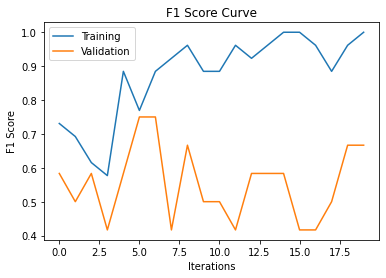

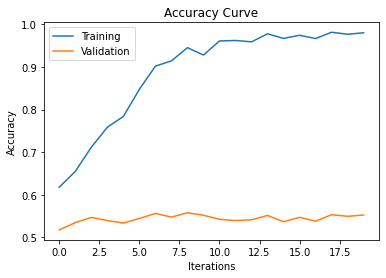

Final Training Accuracy: 0.9806218767351471
Final Validation Accuracy: 0.5524402907580478
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.6666666666666666


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=16, learning_rate=0.001, num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6322777777777778 Validation Accuracy is 0.5155359917141378 . Validation F1 score is 0.5454545454545454
Epoch 1 Finished. Training Accuracy is 0.6875555555555556 Validation Accuracy is 0.525116519937856 . Validation F1 score is 0.5454545454545454
Epoch 2 Finished. Training Accuracy is 0.7655 Validation Accuracy is 0.5546349041947177 . Validation F1 score is 0.5909090909090909
Epoch 3 Finished. Training Accuracy is 0.8167222222222222 Validation Accuracy is 0.5636975660279648 . Validation F1 score is 0.4090909090909091
Epoch 4 Finished. Training Accuracy is 0.8638888888888889 Validation Accuracy is 0.5618850336613154 . Validation F1 score is 0.5
Epoch 5 Finished. Training Accuracy is 0.8881111111111111 Validation Accuracy is 0.5455722423614707 . Validation F1 score is 0.45454545454545453
Epoch 6 Finished. Training Accuracy is 0.9244444444444444 Validation Accuracy is 0.5419471776281719 . Validation F1 score i

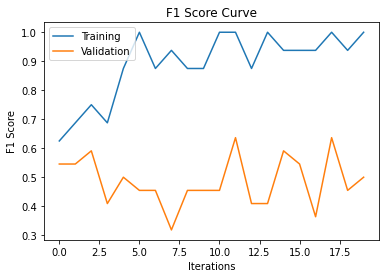

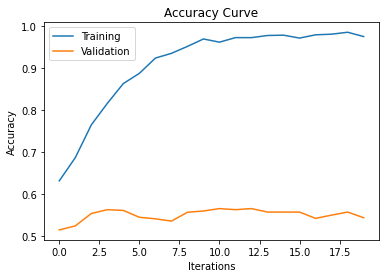

Final Training Accuracy: 0.9756111111111111
Final Validation Accuracy: 0.5445365095805282
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.5


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=16, learning_rate=0.0005, num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6632222222222223 Validation Accuracy is 0.4847229414810979 . Validation F1 score is 0.4090909090909091
Epoch 1 Finished. Training Accuracy is 0.8089444444444445 Validation Accuracy is 0.5020714655618851 . Validation F1 score is 0.36363636363636365
Epoch 2 Finished. Training Accuracy is 0.9118333333333334 Validation Accuracy is 0.5111341273951321 . Validation F1 score is 0.6818181818181818
Epoch 3 Finished. Training Accuracy is 0.9556666666666667 Validation Accuracy is 0.5227861211807354 . Validation F1 score is 0.5
Epoch 4 Finished. Training Accuracy is 0.9750555555555556 Validation Accuracy is 0.53495598135681 . Validation F1 score is 0.6363636363636364
Epoch 5 Finished. Training Accuracy is 0.9787777777777777 Validation Accuracy is 0.516053858104609 . Validation F1 score is 0.36363636363636365
Epoch 6 Finished. Training Accuracy is 0.9695 Validation Accuracy is 0.5196789228379078 . Validation F1 score is

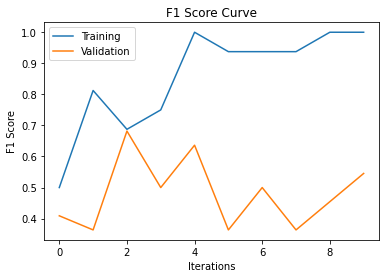

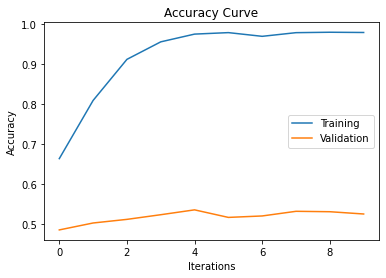

Final Training Accuracy: 0.9791111111111112
Final Validation Accuracy: 0.5245986535473848
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.5454545454545454


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=16, learning_rate=0.0001, num_epochs=10)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6354444444444445 Validation Accuracy is 0.5269290523045055 . Validation F1 score is 0.5
Epoch 1 Finished. Training Accuracy is 0.6904444444444444 Validation Accuracy is 0.53495598135681 . Validation F1 score is 0.5909090909090909
Epoch 2 Finished. Training Accuracy is 0.7623333333333333 Validation Accuracy is 0.5515277058518903 . Validation F1 score is 0.6818181818181818
Epoch 3 Finished. Training Accuracy is 0.8126111111111111 Validation Accuracy is 0.5642154324184361 . Validation F1 score is 0.5909090909090909
Epoch 4 Finished. Training Accuracy is 0.8548888888888889 Validation Accuracy is 0.5445365095805282 . Validation F1 score is 0.5
Epoch 5 Finished. Training Accuracy is 0.8907777777777778 Validation Accuracy is 0.5556706369756603 . Validation F1 score is 0.3181818181818182
Epoch 6 Finished. Training Accuracy is 0.9277777777777778 Validation Accuracy is 0.5489383738995339 . Validation F1 score is 0.5

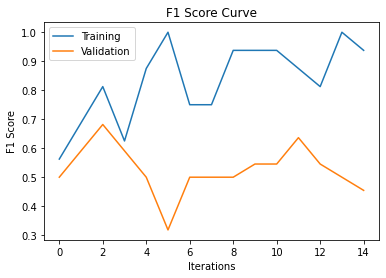

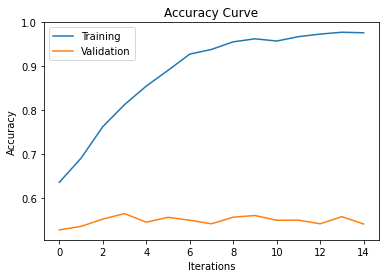

Final Training Accuracy: 0.9765
Final Validation Accuracy: 0.5403935784567582
Final Training F1 Score: 0.9375
Final Validation F1 Score: 0.45454545454545453


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=8, learning_rate=0.0005, num_epochs=15)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6465555555555556 Validation Accuracy is 0.534179181771103 . Validation F1 score is 0.5
Epoch 1 Finished. Training Accuracy is 0.7117222222222223 Validation Accuracy is 0.5336613153806318 . Validation F1 score is 0.5909090909090909
Epoch 2 Finished. Training Accuracy is 0.7997222222222222 Validation Accuracy is 0.5543759709994821 . Validation F1 score is 0.6363636363636364
Epoch 3 Finished. Training Accuracy is 0.8560555555555556 Validation Accuracy is 0.5561885033661316 . Validation F1 score is 0.5
Epoch 4 Finished. Training Accuracy is 0.8969444444444444 Validation Accuracy is 0.5582599689280165 . Validation F1 score is 0.5909090909090909
Epoch 5 Finished. Training Accuracy is 0.9241111111111111 Validation Accuracy is 0.5427239772138788 . Validation F1 score is 0.45454545454545453
Epoch 6 Finished. Training Accuracy is 0.9431666666666667 Validation Accuracy is 0.555152770585189 . Validation F1 score is 0.

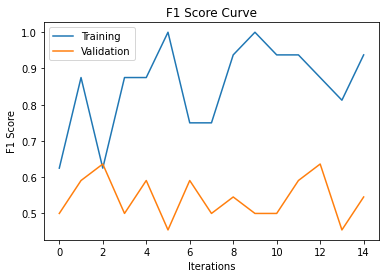

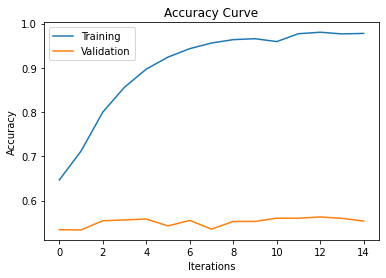

Final Training Accuracy: 0.9776111111111111
Final Validation Accuracy: 0.5535991714137752
Final Training F1 Score: 0.9375
Final Validation F1 Score: 0.5454545454545454


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=8, learning_rate=0.0003, num_epochs=15)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6690555555555555 Validation Accuracy is 0.49430346970481615 . Validation F1 score is 0.5
Epoch 1 Finished. Training Accuracy is 0.8073333333333333 Validation Accuracy is 0.5033661315380632 . Validation F1 score is 0.3181818181818182
Epoch 2 Finished. Training Accuracy is 0.918 Validation Accuracy is 0.5176074572760228 . Validation F1 score is 0.6363636363636364
Epoch 3 Finished. Training Accuracy is 0.9598888888888889 Validation Accuracy is 0.5245986535473848 . Validation F1 score is 0.45454545454545453
Epoch 4 Finished. Training Accuracy is 0.9761666666666666 Validation Accuracy is 0.5253754531330916 . Validation F1 score is 0.5909090909090909
Epoch 5 Finished. Training Accuracy is 0.979 Validation Accuracy is 0.5137234593474883 . Validation F1 score is 0.5
Epoch 6 Finished. Training Accuracy is 0.9807777777777777 Validation Accuracy is 0.5261522527187985 . Validation F1 score is 0.5454545454545454
Epoch 

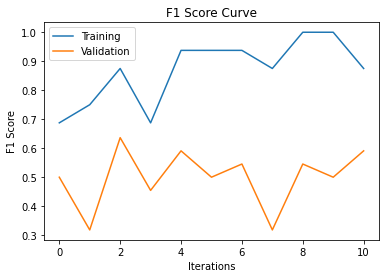

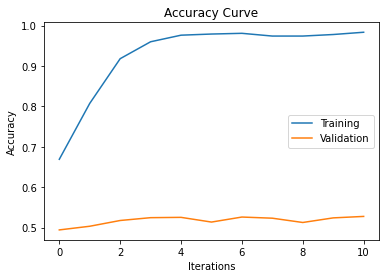

Final Training Accuracy: 0.9834444444444445
Final Validation Accuracy: 0.5277058518902124
Final Training F1 Score: 0.875
Final Validation F1 Score: 0.5909090909090909


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=8, learning_rate=0.0001, num_epochs=11)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.608 Validation Accuracy is 0.5049197307094769 . Validation F1 score is 0.5454545454545454
Epoch 1 Finished. Training Accuracy is 0.611 Validation Accuracy is 0.5095805282237182 . Validation F1 score is 0.45454545454545453
Epoch 2 Finished. Training Accuracy is 0.6968888888888889 Validation Accuracy is 0.5326255825996893 . Validation F1 score is 0.6363636363636364
Epoch 3 Finished. Training Accuracy is 0.7572777777777778 Validation Accuracy is 0.5567063697566028 . Validation F1 score is 0.4090909090909091
Epoch 4 Finished. Training Accuracy is 0.7921111111111111 Validation Accuracy is 0.5445365095805282 . Validation F1 score is 0.5454545454545454
Epoch 5 Finished. Training Accuracy is 0.8471111111111111 Validation Accuracy is 0.5499741066804764 . Validation F1 score is 0.5909090909090909
Epoch 6 Finished. Training Accuracy is 0.8805555555555555 Validation Accuracy is 0.5445365095805282 . Validation F1 score

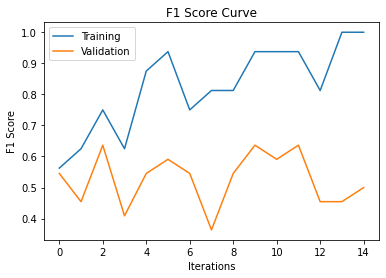

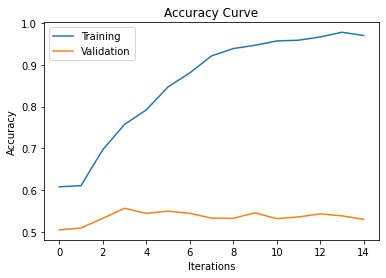

Final Training Accuracy: 0.9701666666666666
Final Validation Accuracy: 0.5302951838425686
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.5


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=128, learning_rate=0.001, num_epochs=15)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=16, learning_rate=0.0005, num_epochs=10)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.5961666666666666 Validation Accuracy is 0.5077679958570689 . Validation F1 score is 0.5
Epoch 1 Finished. Training Accuracy is 0.6518888888888889 Validation Accuracy is 0.5157949249093734 . Validation F1 score is 0.5
Epoch 2 Finished. Training Accuracy is 0.7202777777777778 Validation Accuracy is 0.5416882444329363 . Validation F1 score is 0.5454545454545454
Epoch 3 Finished. Training Accuracy is 0.7823888888888889 Validation Accuracy is 0.5561885033661316 . Validation F1 score is 0.5
Epoch 4 Finished. Training Accuracy is 0.8155 Validation Accuracy is 0.5429829104091144 . Validation F1 score is 0.45454545454545453
Epoch 5 Finished. Training Accuracy is 0.8792222222222222 Validation Accuracy is 0.5533402382185396 . Validation F1 score is 0.4090909090909091
Epoch 6 Finished. Training Accuracy is 0.9107777777777778 Validation Accuracy is 0.5422061108234075 . Validation F1 score is 0.5909090909090909
Epoch 7 

KeyboardInterrupt: ignored

# Model 2

In [ ]:
resnet_model_2 = models.resnet.resnet152(pretrained=True)
num_ftrs = resnet_model_2.fc.in_features
resnet_model_2.fc = nn.Linear(num_ftrs, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model_2 = resnet_model_2.to(device)

In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_2.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_2, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.4411438089950028 Validation Accuracy is 0.3842159916926272 . Validation F1 score is 0.5833333333333334
Epoch 1 Finished. Training Accuracy is 0.5928928373126041 Validation Accuracy is 0.4981827622014538 . Validation F1 score is 0.5
Epoch 2 Finished. Training Accuracy is 0.6375902276513048 Validation Accuracy is 0.5036344755970924 . Validation F1 score is 0.6666666666666666
Epoch 3 Finished. Training Accuracy is 0.6802332037756802 Validation Accuracy is 0.5134994807892004 . Validation F1 score is 0.5833333333333334
Epoch 4 Finished. Training Accuracy is 0.7358134369794559 Validation Accuracy is 0.5220664589823468 . Validation F1 score is 0.5833333333333334
Epoch 5 Finished. Training Accuracy is 0.75247084952804 Validation Accuracy is 0.5173935617860852 . Validation F1 score is 0.75
Epoch 6 Finished. Training Accuracy is 0.791282620766241 Validation Accuracy is 0.5241433021806854 . Validation F1 score is 0.5

KeyboardInterrupt: ignored

# Model 3

In [ ]:
resnet_model_1 = models.resnet.resnet18(pretrained=False)
num_ftrs = resnet_model_1.fc.in_features
resnet_model_1.fc = nn.Linear(num_ftrs, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model_1 = resnet_model_1.to(device)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.5148250971682399 Validation Accuracy is 0.42990654205607476 . Validation F1 score is 0.25
Epoch 1 Finished. Training Accuracy is 0.5754025541365908 Validation Accuracy is 0.4636552440290758 . Validation F1 score is 0.75
Epoch 2 Finished. Training Accuracy is 0.6270960577456969 Validation Accuracy is 0.48286604361370716 . Validation F1 score is 0.5833333333333334
Epoch 3 Finished. Training Accuracy is 0.6990005552470849 Validation Accuracy is 0.5010384215991692 . Validation F1 score is 0.4166666666666667
Epoch 4 Finished. Training Accuracy is 0.7454192115491394 Validation Accuracy is 0.49273104880581514 . Validation F1 score is 0.5833333333333334
Epoch 5 Finished. Training Accuracy is 0.7796224319822321 Validation Accuracy is 0.4961059190031153 . Validation F1 score is 0.5833333333333334
Epoch 6 Finished. Training Accuracy is 0.856024430871738 Validation Accuracy is 0.5002596053997923 . Validation F1 score 

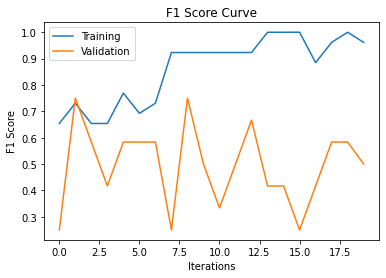

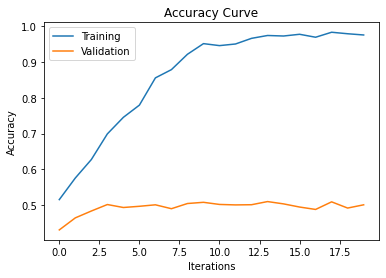

Final Training Accuracy: 0.97623542476402
Final Validation Accuracy: 0.5002596053997923
Final Training F1 Score: 0.9615384615384616
Final Validation F1 Score: 0.5


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_1.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_1, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=20)

# Model 4

In [ ]:
resnet_model_4 = models.resnet.resnet50(pretrained=True)
num_ftrs = resnet_model_4.fc.in_features
resnet_model_4.fc = nn.Sequential(
    nn.Linear(num_ftrs, 600),
    nn.ReLU(True),
    nn.Dropout(0.2),
    nn.Linear(600, 50),
    nn.ReLU(True),
    nn.Dropout(0.2),
    nn.Linear(50, 6)
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model_4 = resnet_model_4.to(device)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.5152777777777777 Validation Accuracy is 0.4295701708959089 . Validation F1 score is 0.45454545454545453
Epoch 1 Finished. Training Accuracy is 0.542 Validation Accuracy is 0.44640082858622476 . Validation F1 score is 0.5454545454545454
Epoch 2 Finished. Training Accuracy is 0.5955555555555555 Validation Accuracy is 0.49922320041429313 . Validation F1 score is 0.5454545454545454
Epoch 3 Finished. Training Accuracy is 0.6282222222222222 Validation Accuracy is 0.5093215950284826 . Validation F1 score is 0.36363636363636365
Epoch 4 Finished. Training Accuracy is 0.6626111111111112 Validation Accuracy is 0.5245986535473848 . Validation F1 score is 0.4090909090909091
Epoch 5 Finished. Training Accuracy is 0.6940555555555555 Validation Accuracy is 0.5196789228379078 . Validation F1 score is 0.36363636363636365
Epoch 6 Finished. Training Accuracy is 0.7221111111111111 Validation Accuracy is 0.5137234593474883 . Va

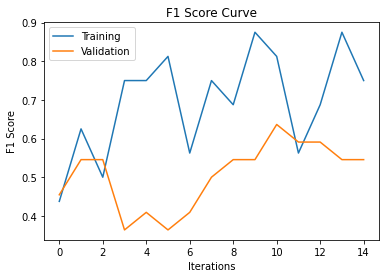

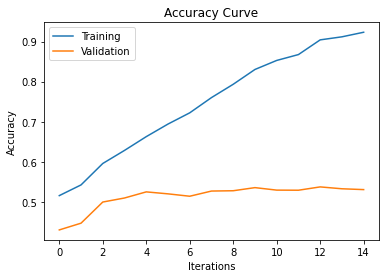

Final Training Accuracy: 0.9234444444444444
Final Validation Accuracy: 0.5302951838425686
Final Training F1 Score: 0.75
Final Validation F1 Score: 0.5454545454545454


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_4.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_4, train_loader, val_loader, batch_size=32, learning_rate=0.001, num_epochs=15)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6165074958356469 Validation Accuracy is 0.5281827622014538 . Validation F1 score is 0.5
Epoch 1 Finished. Training Accuracy is 0.6794169905607996 Validation Accuracy is 0.5489511941848391 . Validation F1 score is 0.5833333333333334
Epoch 2 Finished. Training Accuracy is 0.7352193225985564 Validation Accuracy is 0.5754309449636553 . Validation F1 score is 0.5
Epoch 3 Finished. Training Accuracy is 0.7844142143253748 Validation Accuracy is 0.5575181723779855 . Validation F1 score is 0.5
Epoch 4 Finished. Training Accuracy is 0.8286118822876181 Validation Accuracy is 0.570238836967809 . Validation F1 score is 0.5833333333333334


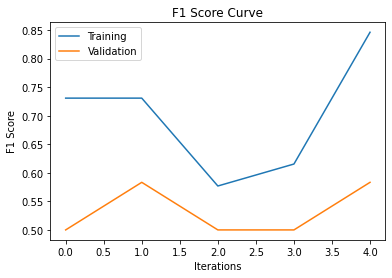

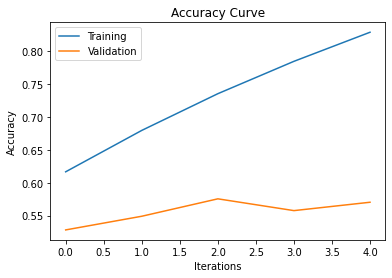

Final Training Accuracy: 0.8286118822876181
Final Validation Accuracy: 0.570238836967809
Final Training F1 Score: 0.8461538461538461
Final Validation F1 Score: 0.5833333333333334


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_4.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_4, train_loader, val_loader, batch_size=32, learning_rate=0.0005, num_epochs=5)

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Training Accuracy is 0.6263353692393115 Validation Accuracy is 0.5390861889927311 . Validation F1 score is 0.6666666666666666
Epoch 1 Finished. Training Accuracy is 0.6686451971127152 Validation Accuracy is 0.5473935617860852 . Validation F1 score is 0.4166666666666667
Epoch 2 Finished. Training Accuracy is 0.7428262076624098 Validation Accuracy is 0.5717964693665628 . Validation F1 score is 0.5833333333333334
Epoch 3 Finished. Training Accuracy is 0.7638145474736258 Validation Accuracy is 0.5720560747663551 . Validation F1 score is 0.3333333333333333
Epoch 4 Finished. Training Accuracy is 0.8323875624652971 Validation Accuracy is 0.5715368639667705 . Validation F1 score is 0.75
Epoch 5 Finished. Training Accuracy is 0.8607051637978901 Validation Accuracy is 0.5523260643821392 . Validation F1 score is 0.4166666666666667
Epoch 6 Finished. Training Accuracy is 0.9089561354802888 Validation Accuracy is 0.5897092419522326 . Validati

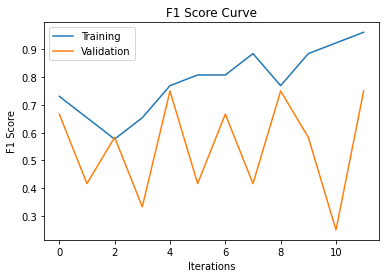

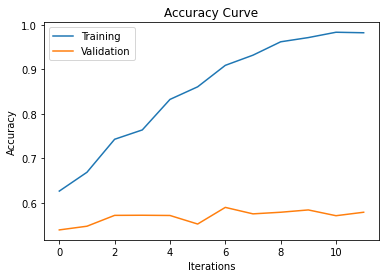

Final Training Accuracy: 0.9821932259855636
Final Validation Accuracy: 0.5788058151609554
Final Training F1 Score: 0.9615384615384616
Final Validation F1 Score: 0.75


In [ ]:
# Use CUDA
if use_cuda and torch.cuda.is_available():
  resnet_model_4.cuda()
  print('CUDA is available!  Training on GPU ...')

train(resnet_model_4, train_loader, val_loader, batch_size=16, learning_rate=0.0005, num_epochs=12)

# Test

In [ ]:
test_model = models.resnet.resnet18(pretrained=True)
num_ftrs = test_model.fc.in_features
test_model.fc = nn.Linear(num_ftrs, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(device)

# restore the best ever model
test_model.load_state_dict(torch.load("/content/gdrive/MyDrive/APS360Project/Model_ResNet_best"))

<All keys matched successfully>

In [ ]:
acc, fs = get_stastics(test_model, test_loader, batch_size=64)

print("Test accuracy:", acc)
print("F1 score:", fs)

Test accuracy: 0.6645077720207254
F1 score: 0.55


In [ ]:
acc, fs = get_stastics(test_model, val_loader, batch_size=64)

print("Validation accuracy:", acc)
print("F1 score:", fs)

Validation accuracy: 0.5867426204039358
F1 score: 0.5909090909090909


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

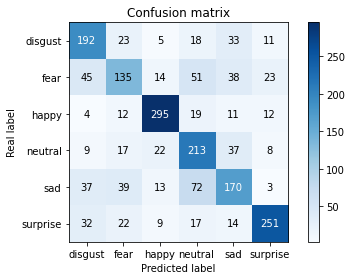

In [ ]:
mat_class = ['', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plot_confusion_matrix(test_model, classes=mat_class, title='Confusion matrix')
plt.show()

# Sample Outputs

In [ ]:
im_transforms = transforms.Compose([transforms.ToTensor()])
# demo image has been stored in the demo directory
# for the presentation purpose, there will be only one image each time
demon_dir = '/content/drive/MyDrive/APS360/Project_dataset/Demo'
# change this !
demo_dataset = datasets.ImageFolder(demon_dir, transform=im_transforms)
demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=1)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored